In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import VGG19
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from google.colab import drive

import glob
from imutils import paths
import numpy as np
from math import floor
import matplotlib.pyplot as plt
import os
import pickle
import random
from shutil import copy2
%matplotlib inline

Using TensorFlow backend.


**Load Drive**

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Constants**

In [0]:
# functionality setup
RENAME_DATA = True
SPLIT_DATA = True

In [0]:
# dirs paths
DRIVE_ROOT = "drive/My Drive"
DATA_DIR = "Data/lecture data"
DATA_PATH = os.path.join(DRIVE_ROOT, DATA_DIR)
LECTURE_DIR = os.path.join(DATA_DIR, "lecture")
NO_LECTURE_DIR = os.path.join(DATA_DIR, "no_lecture")
LECTURE_PATH = os.path.join(DRIVE_ROOT, LECTURE_DIR)
NO_LECTURE_PATH = os.path.join(DRIVE_ROOT, NO_LECTURE_DIR)
CLASSES = ["lecture", "no_lecture"]

# train-val setup
TRAIN_DIR = "train"
TEST_DIR = "test"
VAL_DIR = "val"

TRAIN_FRAC = 0.8
VAL_FRAC = 0.1
TEST_FRAC = 0.1

BATCH_SIZE = 5

# paths 
CSV_PATH = os.path.join(DATA_PATH, "csv")
LE_PATH = os.path.join(DATA_PATH, "le.cpickle")
MODEL_PATH = os.path.join(DATA_PATH, "model.cpickle")

**Renaming data files**

In [8]:
def rename_class_dir(dir_path, class_name):
  print("Renaming files...")
  for i,j in enumerate(glob.glob("{}/*".format(dir_path))):
    _, ext = os.path.splitext(j)
    os.rename(j, "{}/{}_{}.{}".format(dir_path, class_name, i, ext))
  print("Done!")

if RENAME_DATA:
  rename_class_dir(LECTURE_PATH, CLASSES[0])
  rename_class_dir(NO_LECTURE_PATH, CLASSES[1])

Renaming files...
Done!
Renaming files...
Done!


**Create data dirs**

In [14]:
def generate_dir(dir_name):
  print("Generating {} dir...".format(dir_name))
  dir_path = os.path.join(DATA_PATH, dir_name)
  if not os.path.exists(dir_path):
    os.mkdir(dir_path)
  print("Done!")
  return dir_path

if SPLIT_DATA:
  train_path = generate_dir(TRAIN_DIR)
  val_path = generate_dir(VAL_DIR)
  test_path = generate_dir(TEST_DIR)

Generating train dir...
Done!
Generating val dir...
Done!
Generating test dir...
Done!


In [15]:
def make_subdir(dir_path, class_name):
  class_dir = os.path.join(dir_path, class_name)
  if not os.path.exists(class_dir):
    os.mkdir(class_dir)
  return class_dir

def split_dir(dir_path, class_name):
  num_files = len(os.listdir(dir_path))
  num_train = floor(TRAIN_FRAC * num_files)
  num_val = floor(VAL_FRAC * num_files)

  train_class_dir = make_subdir(train_path, class_name)
  val_class_dir = make_subdir(val_path, class_name)
  test_class_dir = make_subdir(test_path, class_name)

  image_files = glob.glob("{}/*".format(dir_path))
  random.shuffle(image_files)

  for i,j in enumerate(image_files):
    if i < num_train:
      copy2(j, train_class_dir)
    elif i >= num_train and i < num_train + num_val:
      copy2(j, val_class_dir)
    else:
      copy2(j, test_class_dir)

if SPLIT_DATA:
  print("Spliting data files...")
  split_dir(LECTURE_PATH, CLASSES[0])
  split_dir(NO_LECTURE_PATH, CLASSES[1])
  print("Done!")

Spliting data files...
Done!


**Load VGG19 pretrained network**

In [16]:
print("loading network...")
net_model = VGG19(weights="imagenet", include_top=False)
print("Done!")
#initialize label encoder
le = None

loading network...




80142336/80134624 [==============================] - 6s 0us/step






Done!


**Run data through network and save results**

In [17]:
def preprocess_image(image_path):
	# load the input image using the Keras helper utility
	# while ensuring the image is resized to 224x224 pixels
	image = load_img(image_path, target_size=(224, 224))
	image = img_to_array(image)

	# preprocess the image by (1) expanding the dimensions and
	# (2) subtracting the mean RGB pixel intensity from the
	# ImageNet dataset
	image = np.expand_dims(image, axis=0)
	return imagenet_utils.preprocess_input(image)

def run_net_model():
	global le
	# loop over the data splits
	for split in (TRAIN_DIR, TEST_DIR, VAL_DIR):
		# grab all image paths in the current split
		print("processing '{} split'...".format(split))
		p = os.path.join(DATA_PATH, split)
		image_paths = list(paths.list_images(p))

		# randomly shuffle the image paths and then extract the class
		# labels from the file paths
		random.shuffle(image_paths)
		labels = [p.split(os.path.sep)[-2] for p in image_paths]

		# if the label encoder is None, create it
		if le is None:
			le = LabelEncoder()
			le.fit(labels)

		# open the output CSV file for writing
		csv_split_path = os.path.sep.join([CSV_PATH,
			"{}.csv".format(split)])
		csv = open(csv_split_path, "w")

		# loop over the images in batches
		for (b, i) in enumerate(range(0, len(image_paths), BATCH_SIZE)):
			# extract the batch of images and labels, then initialize the
			# list of actual images that will be passed through the network
			# for feature extraction
			print("processing batch {}/{}".format(b + 1,
				int(np.ceil(len(image_paths) / float(BATCH_SIZE)))))
			batch_paths = image_paths[i:i + BATCH_SIZE]
			batch_labels = le.transform(labels[i:i + BATCH_SIZE])
			batch_images = []

			# loop over the images and labels in the current batch
			for image_path in batch_paths:
				image = preprocess_image(image_path)

				# add the image to the batch
				batch_images.append(image)

			# pass the images through the network and use the outputs as
			# our actual features, then reshape the features into a
			# flattened volume
			batch_images = np.vstack(batch_images)
			features = net_model.predict(batch_images, batch_size=BATCH_SIZE)
			features = features.reshape((features.shape[0], 7 * 7 * 512))

			# loop over the class labels and extracted features
			for (label, vec) in zip(batch_labels, features):
				# construct a row that exists of the class label and
				# extracted features
				vec = ",".join([str(v) for v in vec])
				csv.write("{},{}\n".format(label, vec))

		# close the CSV file
		csv.close()

os.chdir("/content/")
if not os.path.exists(CSV_PATH):
	os.mkdir(CSV_PATH)

run_net_model()

# serialize the label encoder to disk
f = open(LE_PATH, "wb")
f.write(pickle.dumps(le))
f.close()

processing 'train split'...
processing batch 1/20
processing batch 2/20
processing batch 3/20
processing batch 4/20
processing batch 5/20
processing batch 6/20
processing batch 7/20
processing batch 8/20
processing batch 9/20
processing batch 10/20
processing batch 11/20
processing batch 12/20
processing batch 13/20
processing batch 14/20
processing batch 15/20
processing batch 16/20
processing batch 17/20
processing batch 18/20
processing batch 19/20
processing batch 20/20
processing 'test split'...
processing batch 1/3
processing batch 2/3
processing batch 3/3
processing 'val split'...
processing batch 1/3
processing batch 2/3
processing batch 3/3


**Load data from disk**

In [0]:
def load_data_split(split_path):
	# initialize the data and labels
	data = []
	labels = []
 
	# loop over the rows in the data split file
	for row in open(split_path):
		# extract the class label and features from the row
		row = row.strip().split(",")
		label = row[0]
		features = np.array(row[1:], dtype="float")
 
		# update the data and label lists
		data.append(features)
		labels.append(label)
 
	# convert the data and labels to NumPy arrays
	data = np.array(data)
	labels = np.array(labels)
 
	# return a tuple of the data and labels
	return (data, labels)

In [19]:
# derive the paths to the training and testing CSV files
training_path = os.path.join(CSV_PATH,
	"{}.csv".format(TRAIN_DIR))
testing_path = os.path.join(CSV_PATH,
	"{}.csv".format(TEST_DIR))
 
# load the data from disk
print("Loading data...")
(trainX, trainY) = load_data_split(training_path)
(testX, testY) = load_data_split(testing_path)
print("Done!")
 
# load the label encoder from disk
le = pickle.loads(open(LE_PATH, "rb").read())

Loading data...
Done!


**Train logistic regression model**

In [20]:
print("Training model...")
lr_model = LogisticRegression(solver="lbfgs", multi_class="auto")
lr_model.fit(trainX, trainY)
print("Done!")

Training model...
Done!


**Evaluate model**

In [21]:
print("Evaluating...")
preds = lr_model.predict(testX)
print(classification_report(testY, preds, target_names=le.classes_))

Evaluating...
              precision    recall  f1-score   support

     lecture       1.00      1.00      1.00         8
  no_lecture       1.00      1.00      1.00         7

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



**Save model**

In [22]:
print("Saving model...")
f = open(MODEL_PATH, "wb")
f.write(pickle.dumps(lr_model))
f.close()
print("Done!")

Saving model...
Done!


In [23]:
from sklearn.externals import joblib
lr_model = joblib.load(MODEL_PATH)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


**Predict example**

prediction: no_lecture


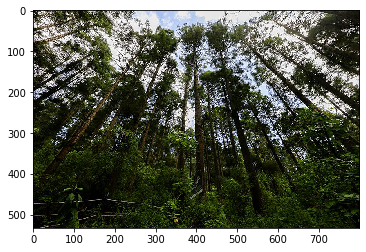

In [24]:
def pick_test_image(class_name=""):
  p = os.path.join(DATA_PATH, TEST_DIR)
  if class_name != "":
    p = os.path.join(p, class_name)    
  image_paths = list(paths.list_images(p))
  rand_ind = random.randint(0, len(image_paths)-1)
  test_img_path = image_paths[rand_ind]
  return test_img_path

def show_prediction(test_img_path, pred):
  print("prediction: {}".format(CLASSES[int(pred)]))
  img = plt.imread(test_img_path)
  plt.imshow(img)
  plt.show()

def predict_rand_img(class_name=""):
  # load image
  test_img_path = pick_test_image(class_name)
  test_img_prep = preprocess_image(test_img_path)

  # run through network and linear regressor
  features = net_model.predict(test_img_prep, batch_size=1)
  features = features.reshape((features.shape[0], 7 * 7 * 512))
  pred = lr_model.predict(features)

  return test_img_path, pred

show_prediction(*predict_rand_img())